In [65]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy import special
import random

So, we have seen that the MCMC method is accurate but it takes a while because we are starting from quite a few poisitions. The BRUTE function is quicker but less accurate. I think that using one of the functions form the BRUTE method to quickly find a few good starting poisitions for the MCMC would get the best from both. We can also speed up the MCMC by considering less points and betas / props can probably be reduced without changing the accuracy much.

We want this to be efficient since the plan is to input many different matrix elements to work out the best transitions to use.

In [103]:
#Define all of the frequencies we care about (we are working in MHz and are ignoring the 2pi for now to make things easy - also, frequencies are rounded) - these numbers don't actually matter.
#The setup is a bit difficult, so everything is carefully laid out: - the actual frequencies don't matter here but it does matter if one is a multiple of another.

DwG = 8000      #Ground state splitting
DwM = 60        #Metastable state splitting
Dw = 170.26e6   #Difference between the lowest metastable state and the highest ground state

#We are defining the frequency to be sitting above the 
Dw1 = DwM      #Where the unmodulated signal is sitting above the lowest ground state

#Define the frequency at which we have parked the beam - this is the most general way of defining the beam since
w = (DwG - Dw1) + Dw

#Define the frequencies that we wish to find:
w1 = Dw
w2 = Dw + DwM
w3 = Dw + DwG
w4 = Dw + DwG + DwM

#Define the frequencies we wish to modulate at:
W = [DwG,DwG-Dw1,DwM]

Order = 2   #Considering up to this order.

M = [1,1.1,0.9,1.01]   #the matrix elements for each transition

In [104]:
def COMBO(Order,W,M,Rinitial,Spacings,NumberOfPoints,Betas,Props,N,StepSize):

    Index_history = []
    Func_history = []
    Diff_history = []
    Eff_history = []

    #define variables that are used within this function:

    ###First step is to define all of the possible combinations from the given frequencies and then work out the amplitudes for each tone
    #Work out how to make w1,w2,w3 and w4 using wm1,wm2 and wm3 from w. Consider only O orders.
    values = range(-Order, Order + 1)  # from -Order to Order

    Mod = []
    #intertools produces all possible combinations of elements
    for p in itertools.product(values, repeat = np.size(W)):     # this creates a list of all the possible combinations of each modulation frequency: we are making p a list rather than a tuple
        Mod.append(p)

    #filter out all of the combinations that we won't use and create a list of all of the useful ones:
    Combinations = []       #Define a list of all of the combinations for each frequency. Each component will be: [frequency that this adds up to, no. of W[0],...,no. of W[N]]
    for list in Mod:

        #find the frequency when summing up the modulation frequencies as described by this component of Mod:
        freq = w
        for x in range(np.size(W)):
            freq += int (list[x] * W[x])

        #now, we want to see if this frequency is useful at all:
        if freq == w1:
            Combinations.append([1,list])
        if freq == w2:
            Combinations.append([2,list])
        if freq == w3:
            Combinations.append([3,list])
        if freq == w4:
            Combinations.append([4,list])
    print(Combinations)
    #Define a function that outputs the amplitude for this sideband
    def A(Orders,ModIndices):
        A = 1
        for x in range(np.size(ModIndices)):
            A *= special.jv(Orders[x], ModIndices[x])
        return(A)

    #Define a function to find the amplitudes for each of the frequencies
    def FindAmps(Combinations,ModIndices):
        Amps = [0,0,0,0]

        for i in range(0, np.size(Amps)):   #i represents which frequency we are looking at
            for orders in Combinations:     #we will go through all combinations
                if orders[0] == i+1:        #the 0th index indicates which transition it is e.g. 1 is for w1
                    Amps[i] += A(orders[1],ModIndices)  #this will add the amplitude to the correct ith part of Amps where the ith term represents the amplitude for wi

        #Make the amplitudes absolute since their signs no longer matter (no more intereference):
        return(np.abs(Amps))
    
    #define a function to use these two previous functions to work out the maximum difference between the Rabi frequencies and the efficiency at these modulation indices
    def DiffAndEff(Combinations,ModIndices,M):
        Amps = FindAmps(Combinations,ModIndices)

        #create a list of the relative Rabi frequencies:
        Rabis = []
        for x in range(0,np.size(Amps)):
            Rabis.append( abs( Amps[x]*M[x]) )

        mean = sum(Rabis) / np.size(Rabis)

        #define the maximum difference relative to the mean Rabi frequency:
        MaxDiff = (max(Rabis) - min(Rabis)) / mean

        #also work out the efficiency:
        Efficiency = 0
        for x in range(0,np.size(Amps)):
            Efficiency += Amps[x] ** 2

        return(MaxDiff,Efficiency)

    ###Up to here has been the same for both functions. The next step is to define the MCMC 'energy' and to minimise it with the MCMC algorithm
    #this is the function:
    def func(Diff, Eff, prop):
        func = Diff * (1 - Eff) ** prop
        return(func)

    #and a function for our random steps:
    def choice(beta, func, Newfunc):
            prob = np.exp( beta * ( (func - Newfunc) / (0.5 * func + 0.5 * Newfunc))) # make this the mean so that as the function gets smaller, we still have random steps
            decision = random.choices([1 , 0] , [prob, 1-prob])
            return(decision[0])

    #first, we want to find a few good starting points using a brute force method:
    #define a function to find the initial points.
    def BestIndices(NumberOfPoints,R,spacing,Combinations):

        #define all of the points we are calculating values at for every point in this mesh
        X = np.linspace(R[0][0], R[0][1], int( (R[0][1] - R[0][0]) / (spacing) + 1) )
        Y = np.linspace(R[1][0], R[1][1], int( (R[1][1] - R[1][0]) / (spacing) + 1) )
        Z = np.linspace(R[2][0], R[2][1], int( (R[2][1] - R[2][0]) / (spacing) + 1) )

        AllIndices = [] #save all of the indices
        AllDiffs = []  #save all of the differences

        for x in range(np.size(X)):
            for y in range(np.size(Y)):
                for z in range(np.size(Z)):
                    Indices = [X[x],Y[y],Z[z]]       #the point we are considering
                    MaxDiff, _ = DiffAndEff(Combinations,Indices,M)
                    AllIndices.append(Indices)
                    AllDiffs.append(MaxDiff)

        # get indices of the three smallest diffs
        NextPoints = []
        for x in range(0,NumberOfPoints):
            index = AllDiffs.index(min(AllDiffs))
            NextPoints.append( AllIndices[index] )
            del AllDiffs[index]
            del AllIndices[index]

        return(NextPoints)       #returning the three points that had the smallest difference in Rabi frequencies

    #then immediately call this function:
    #find the initial points:
    ModIndices = BestIndices(NumberOfPoints,Rinitial,Spacings,Combinations)
    #define the MCMC for these variables:
    def MCMC_Variables(ModIndices,Beta,Prop,N,StepSize):

        #these are all the things we want to record:
        Diff_history = []
        Eff_history = []
        func_history = []
        Index_history = []

        #run the loops:
        for i in range(0,N): 
            #start off with adding to modulation indices, then subtract.
            for sign in range(0,2):

                #see if changing the modulation index by a small step does anything, change F accordingly
                for x in range(np.size(ModIndices)):
                    
                    #make a copy of the indices, modified by the step
                    NewModIndices = ModIndices.copy()
                    NewModIndices[x] += (-1) ** sign * StepSize

                    #find the difference and efficiency for each
                    Diff, Eff = DiffAndEff(Combinations,ModIndices,M)
                    F = func(Diff, Eff, Prop)

                    NewDiff, NewEff = DiffAndEff(Combinations,NewModIndices,M)
                    NewF = func(NewDiff, NewEff, Prop)
                    
                    if NewF < F:
                        ModIndices = NewModIndices    #make the forwards step if we can
                        #save the new values (which may be the same as the old values)
                        func_history.append(NewF)
                        Diff_history.append(NewDiff)
                        Eff_history.append(NewEff)
                        Index_history.append(NewModIndices)
                    
                    else:
                        if choice(Beta,F,NewF) == 1:
                            ModIndices = NewModIndices    #make a backwards step sometimes, with more probability if the step is small
                            #save the new values (which may be the same as the old values)
                            func_history.append(NewF)
                            Diff_history.append(NewDiff)
                            Eff_history.append(NewEff)
                            Index_history.append(NewModIndices)
                        else:

                            #save the new values (which may be the same as the old values)
                            func_history.append(F)
                            Diff_history.append(Diff)
                            Eff_history.append(Eff)
                            Index_history.append(ModIndices)

        return(Index_history,func_history,Diff_history,Eff_history)

    #iterate over all points
    for p in ModIndices:
        #iterate over all betas
        for B in Betas:
            #iterate over all proportions
            for Prop in Props:
                    #run the algorithm for these variables
                    TempIndex_history,TempFunc_history,TempDiff_history,TempEff_history = MCMC_Variables(p,B,Prop,N,StepSize)
                    Index_history.append(TempIndex_history)
                    Func_history.append(TempFunc_history)
                    Diff_history.append(TempDiff_history)
                    Eff_history.append(TempEff_history)
    
    #flatten out these arrays:
    TempIndex_history, Func_history, Diff_history, Eff_history = np.array(Index_history), np.array(Func_history), np.array(Diff_history), np.array(Eff_history)
    TempIndex_history, Func_history, Diff_history, Eff_history =  TempIndex_history.flatten(), Func_history.flatten(), Diff_history.flatten(), Eff_history.flatten()

    #make the index history into the right shape
    n = int( np.size(W) )  # group size
    Index_history = [ TempIndex_history[i:i + n] for i in range(0, len(TempIndex_history), n)]

    Index_history = np.array(Index_history) # I'm not sure why but this needs to be told it's a numpy array again

    return(Index_history, Func_history, Diff_history, Eff_history)

In [142]:
#Call the COMBOA function:

#Use code from the brute force method to convert a range and spacing into a lattice of indices
Rinitial = [ [0.1,1.8] , [0.1,1.8] , [0.1,2.4] ]
Spacings = 0.1
NumberOfPoints = 8

StepSize = 0.001
Betas = [3000,5000]
Props = [3,5]
N = 10**3

COMBOIndices, COMBOFuncs, COMBODiffs, COMBOEffs = COMBO(Order,W,M,Rinitial,Spacings,NumberOfPoints,Betas,Props,N,StepSize)

[[1, (-2, 1, 2)], [1, (-1, 0, 1)], [2, (-1, 0, 2)], [3, (-1, 1, 2)], [1, (0, -1, 0)], [2, (0, -1, 1)], [3, (0, 0, 1)], [4, (0, 0, 2)], [1, (1, -2, -1)], [2, (1, -2, 0)], [3, (1, -1, 0)], [4, (1, -1, 1)], [3, (2, -2, -1)], [4, (2, -2, 0)]]


In [143]:
###Find the result - first reduce to only Diffs within our criteria and then choose the highest efficiency from this.
mask = COMBODiffs <= min(COMBODiffs) #0.001
TempIndices = COMBOIndices[mask]
TempDiffs = COMBODiffs[mask]
TempEffs = COMBOEffs[mask]

index = np.argmax(TempEffs)
IndicesResult = TempIndices[index]
DiffResult = TempDiffs[index]
EffResult = max(TempEffs)

print(IndicesResult)
print(DiffResult)
print(EffResult)


[1.347 0.027 2.492]
0.003368762969340302
0.2823102007581924


In [ ]:
#call COMBO again just to walk around the result:
Rinitial2 = []
for i in range(0,3):
    Rinitial2.append([IndicesResult[i] - 0.1, IndicesResult[i] + 0.1])
Spacings2 = 0.1
NumberOfPoints2 = 3

StepSize2 = 0.001
Betas2 = [3000,5000]
Props2 = [3,5]
N2 = 5*10**2

COMBOIndices2, COMBOFuncs2, COMBODiffs2, COMBOEffs2 = COMBO(Order,W,M,Rinitial2,Spacings2,NumberOfPoints2,Betas2,Props2,N2,StepSize2)

[[1, (-2, 1, 2)], [1, (-1, 0, 1)], [2, (-1, 0, 2)], [3, (-1, 1, 2)], [1, (0, -1, 0)], [2, (0, -1, 1)], [3, (0, 0, 1)], [4, (0, 0, 2)], [1, (1, -2, -1)], [2, (1, -2, 0)], [3, (1, -1, 0)], [4, (1, -1, 1)], [3, (2, -2, -1)], [4, (2, -2, 0)]]


In [152]:
###Find the result - first reduce to only Diffs within our criteria and then choose the highest efficiency from this.
mask = COMBODiffs2 <= min(COMBODiffs2) #0.001
TempIndices2 = COMBOIndices2[mask]
TempDiffs2 = COMBODiffs2[mask]
TempEffs2 = COMBOEffs2[mask]

index = np.argmax(TempEffs2)
IndicesResult2 = TempIndices2[index]
DiffResult2 = TempDiffs2[index]
EffResult2 = max(TempEffs2)

print(IndicesResult2)
print(DiffResult2)
print(EffResult2)

[1.35  0.021 2.495]
0.0004209268741813851
0.28210347880813336


In [117]:
### it would take too long to consider the combinations of every possible term, so this will plot only the frequencies we want:

#Show the spectrum after modulation with these indices:

#use code from within the function that found the amplitudes we were looking for:
values = range(-Order, Order + 1)  # from -Order to Order
Mod = []
NumberOfPlots = 0   #this is the number of indices in Mod
#intertools produces all possible combinations of elements
for p in itertools.product(values, repeat = np.size(W)):
    NumberOfPlots += 1
    Mod.append(p)

#Put the tones we like into a different list:
Combinations = []
for list in Mod:

    freq = w
    for x in range(np.size(W)):
        freq += list[x] * W[x]

    if freq == w1:
        Combinations.append([1,list])
    if freq == w2:
        Combinations.append([2,list])
    if freq == w3:
        Combinations.append([3,list])
    if freq == w4:
        Combinations.append([4,list])
#so, Mod has all of the combinations, Combinations has only the useful ones.

#Define a function that outputs the amplitude for this sideband
def A(Orders,ModIndices):
    A = 1
    for x in range(np.size(ModIndices)):
        A *= special.jv(Orders[x], ModIndices[x])
    return(A)

#Define a function to find the amplitudes for each of the frequencies
def FindAmps(Combinations,ModIndices):
    Amps = [0,0,0,0]

    for i in range(0, np.size(Amps)):   #i represents which frequency we are looking at
        for orders in Combinations:     #we will go through all combinations
            if orders[0] == i+1:        #the 0th index indicates which transition it is e.g. 1 is for w1
                Amps[i] += A(orders[1],ModIndices)  #this will add the amplitude to the correct ith part of Amps where the ith term represents the amplitude for wi

    return(Amps)

Amps = np.abs(FindAmps(Combinations,IndicesResult))

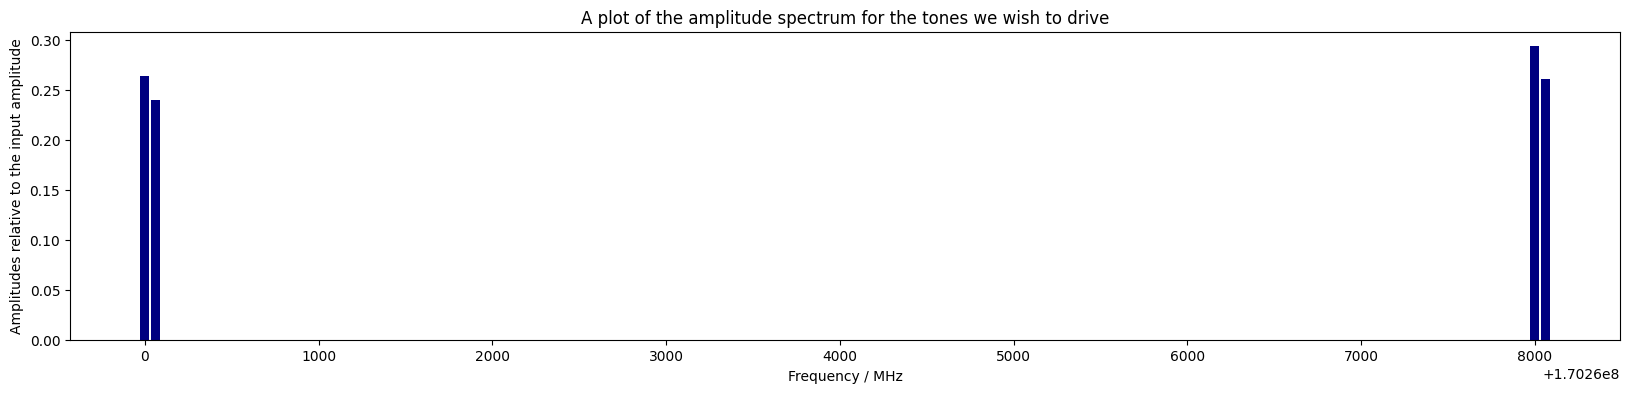

In [118]:
#plot the power spectrum
plt.figure(figsize=(20,4))
plt.bar([w1,w2,w3,w4], Amps,width=50, color='navy')

plt.xlabel('Frequency / MHz')
plt.ylabel('Amplitudes relative to the input amplitude')
plt.title('A plot of the amplitude spectrum for the tones we wish to drive')
plt.show()

d:\VSfolder\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


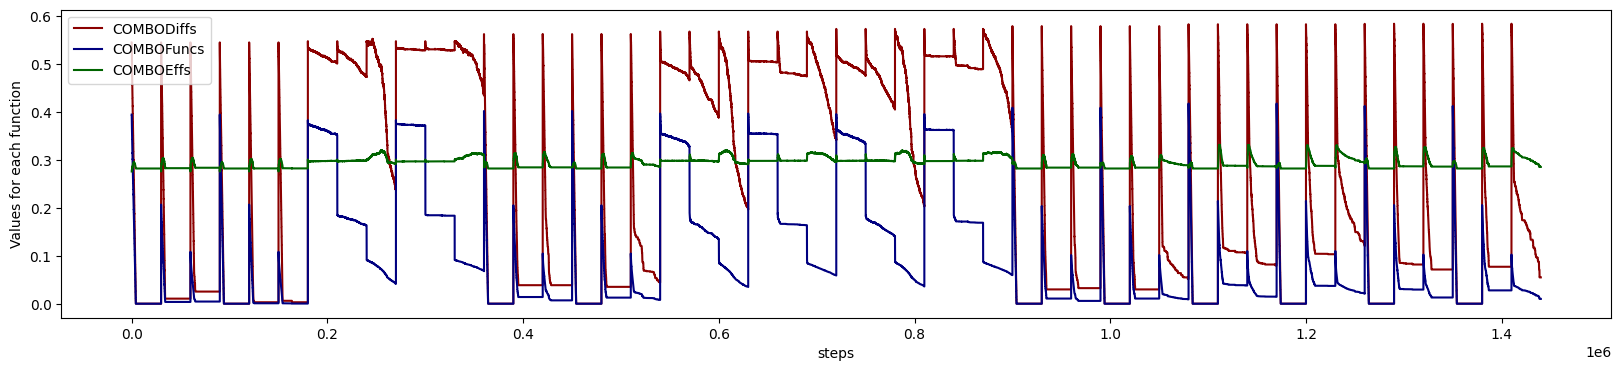

In [120]:
##visualise what is going on in the simulation:
steps = np.linspace(1,np.size(COMBODiffs),np.size(COMBODiffs))

plt.figure(figsize=(20,4))
plt.plot(steps,COMBODiffs, color='darkred', label = 'COMBODiffs')
plt.plot(steps,COMBOFuncs, color='navy', label = 'COMBOFuncs')
plt.plot(steps,COMBOEffs, color='darkgreen', label = 'COMBOEffs')

plt.legend()
plt.ylabel('Values for each function')
plt.xlabel('steps')
plt.show()